<a href="https://colab.research.google.com/github/BhumikaAdhya05/JU_Research/blob/main/PANet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhumikaadhya05","key":"76f7c91a508c639053f3ec8ca5a655a0"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d orvile/bus-uclm-breast-ultrasound-dataset

Dataset URL: https://www.kaggle.com/datasets/orvile/bus-uclm-breast-ultrasound-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 94% 603M/642M [00:03<00:00, 185MB/s]
100% 642M/642M [00:04<00:00, 144MB/s]


In [4]:
import zipfile
import os

with zipfile.ZipFile("bus-uclm-breast-ultrasound-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

In [5]:
for root, dirs, files in os.walk('./data'):
    print(root, "->", len(files), "files")

./data -> 0 files
./data/BUS-UCLM Breast ultrasound lesion segmentation dataset -> 0 files
./data/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM Breast ultrasound lesion segmentation dataset -> 0 files
./data/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM -> 1 files
./data/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM/masks -> 683 files
./data/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM/images -> 683 files
./data/bus_uclm_separated -> 0 files
./data/bus_uclm_separated/normal -> 419 files
./data/bus_uclm_separated/malign -> 90 files
./data/bus_uclm_separated/benign -> 174 files


In [6]:
IMG_DIR = './data/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM/images'
MASK_DIR = './data/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM/masks'

print("Total Images:", len(os.listdir(IMG_DIR)))
print("Total Masks:", len(os.listdir(MASK_DIR)))

Total Images: 683
Total Masks: 683


In [7]:
import random
import torch
from torch.utils.data import Dataset
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

class EpisodicBUSDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=256, n_shot=1):
        self.img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.png')])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])
        self.img_size = img_size
        self.n_shot = n_shot

    def __len__(self):
        return 1000  # Number of episodes

    def __getitem__(self, idx):
        indices = random.sample(range(len(self.img_paths)), self.n_shot + 1)
        support_imgs, support_masks = [], []

        for i in range(self.n_shot):
            img = cv2.imread(self.img_paths[indices[i]], cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(self.mask_paths[indices[i]], cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size)) / 255.0
            mask = cv2.resize(mask, (self.img_size, self.img_size)) / 255.0
            support_imgs.append(img)
            support_masks.append(mask)

        query_img = cv2.imread(self.img_paths[indices[-1]], cv2.IMREAD_GRAYSCALE)
        query_mask = cv2.imread(self.mask_paths[indices[-1]], cv2.IMREAD_GRAYSCALE)
        query_img = cv2.resize(query_img, (self.img_size, self.img_size)) / 255.0
        query_mask = cv2.resize(query_mask, (self.img_size, self.img_size)) / 255.0

        support_imgs = torch.tensor(support_imgs).unsqueeze(1).float()  # [N, 1, H, W]
        support_masks = torch.tensor(support_masks).unsqueeze(1).float()
        query_img = torch.tensor(query_img).unsqueeze(0).float()        # [1, H, W]
        query_mask = torch.tensor(query_mask).unsqueeze(0).float()

        return support_imgs, support_masks, query_img, query_mask

/tmp/ipython-input-7-2932824952.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  support_imgs = torch.tensor(support_imgs).unsqueeze(1).float()  # [N, 1, H, W]


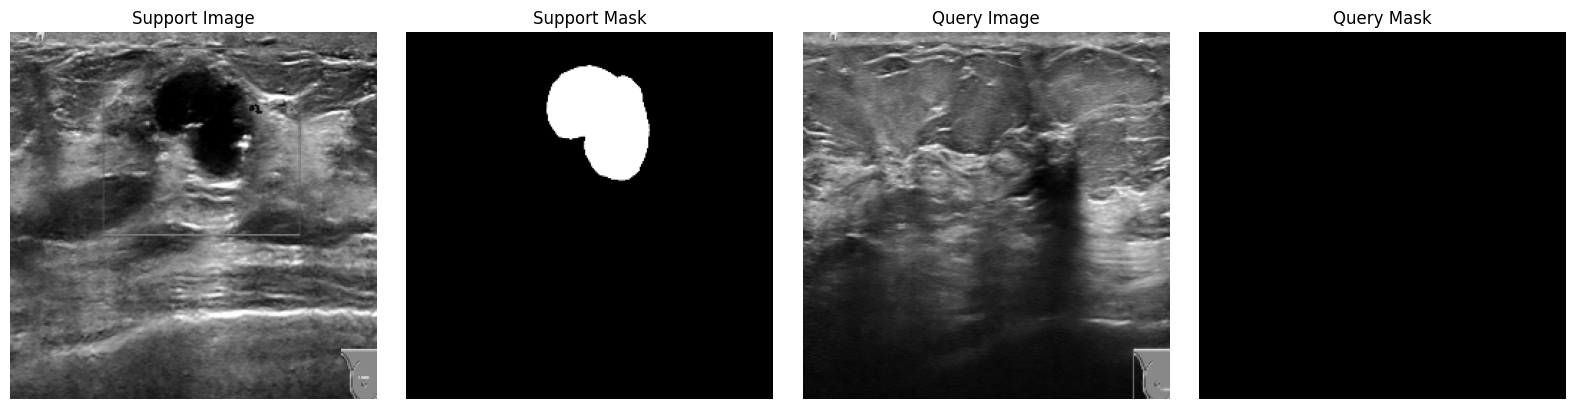

In [8]:
# Test loader
dataset = EpisodicBUSDataset(IMG_DIR, MASK_DIR, img_size=256, n_shot=1)
support_imgs, support_masks, query_img, query_mask = dataset[0]

# Visualize
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].imshow(support_imgs[0][0].numpy(), cmap='gray')
ax[0].set_title("Support Image")
ax[1].imshow(support_masks[0][0].numpy(), cmap='gray')
ax[1].set_title("Support Mask")
ax[2].imshow(query_img[0].numpy(), cmap='gray')
ax[2].set_title("Query Image")
ax[3].imshow(query_mask[0].numpy(), cmap='gray')
ax[3].set_title("Query Mask")

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

In [9]:
import torch.nn as nn
from torchvision import models

class FeatureEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Output: [B, 2048, H/32, W/32]

    def forward(self, x):
        # x: [B, 1, H, W] → repeat channels to [B, 3, H, W]
        x = x.repeat(1, 3, 1, 1)
        return self.encoder(x)

In [10]:
# Test encoder on query image
encoder = FeatureEncoder()
encoder.eval()

with torch.no_grad():
    query_feat = encoder(query_img.unsqueeze(0))  # [1, 1, H, W] → [1, 3, H, W] internally
    print("Encoded query feature shape:", query_feat.shape)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


Encoded query feature shape: torch.Size([1, 2048, 8, 8])


In [22]:
class PANet(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

        # Decoder: Upsample similarity map to original size
        self.decoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False),  # from 8x8 → 256x256
            nn.Conv2d(16, 1, 1),
            nn.Sigmoid()
        )

    def compute_prototype(self, support_feats, support_masks):
        """
        support_feats: [N, C, H, W]
        support_masks: [N, 1, H, W]
        Returns: [1, C, 1, 1] prototype vector
        """
        masked_feats = support_feats * support_masks
        proto = masked_feats.sum(dim=(0, 2, 3)) / (support_masks.sum(dim=(0, 2, 3)) + 1e-6)
        return proto.view(1, -1, 1, 1)  # [1, C, 1, 1]

    def forward(self, support_imgs, support_masks, query_img):
        # Encode support and query
        support_feats = self.encoder(support_imgs)      # [N, C, H', W']
        query_feat = self.encoder(query_img)  # [1, C, H', W']

        # Resize support masks to match support_feats resolution
        support_masks = nn.functional.interpolate(support_masks, size=support_feats.shape[2:], mode='bilinear', align_corners=False)

        # Compute prototype
        proto = self.compute_prototype(support_feats, support_masks)

        # Cosine similarity: [1, 1, H', W']
        similarity = nn.functional.cosine_similarity(query_feat, proto, dim=1, eps=1e-7).unsqueeze(1)

        # Decode similarity map to segmentation
        out = self.decoder(similarity)
        return out

In [23]:
# Initialize model
model = PANet(encoder)

# Run test inference
with torch.no_grad():
    pred_mask = model(support_imgs, support_masks, query_img)
    print("Predicted mask shape:", pred_mask.shape)

Predicted mask shape: torch.Size([1, 1, 256, 256])


In [24]:
def dice_loss(pred, target, eps=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + eps) / (pred.sum() + target.sum() + eps))

In [25]:
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to GPU
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# DataLoader
train_dataset = EpisodicBUSDataset(IMG_DIR, MASK_DIR, img_size=256, n_shot=1)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [82]:
print("query_img shape before encoder:", query_mask.squeeze(2).shape)

query_img shape before encoder: torch.Size([1, 1, 256, 256])


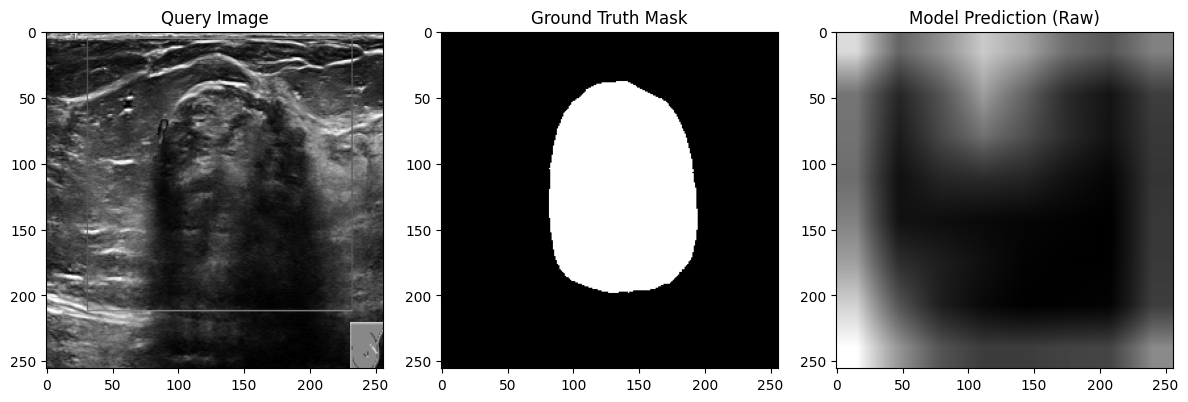

[Epoch 1] Episode 10 | Loss: 1.2433
[Epoch 1] Episode 20 | Loss: 1.0677
[Epoch 1] Episode 30 | Loss: 1.2418
[Epoch 1] Episode 40 | Loss: 1.2408
[Epoch 1] Episode 50 | Loss: 1.2398
[Epoch 1] Episode 60 | Loss: 1.2389
[Epoch 1] Episode 70 | Loss: 1.2317
[Epoch 1] Episode 80 | Loss: 1.2224
[Epoch 1] Episode 90 | Loss: 1.2368
[Epoch 1] Episode 100 | Loss: 1.2845
[Epoch 1] Episode 110 | Loss: 1.2354
[Epoch 1] Episode 120 | Loss: 1.0543
[Epoch 1] Episode 130 | Loss: 1.2241
[Epoch 1] Episode 140 | Loss: 1.0737
[Epoch 1] Episode 150 | Loss: 1.2318
[Epoch 1] Episode 160 | Loss: 1.2626
[Epoch 1] Episode 170 | Loss: 1.2181
[Epoch 1] Episode 180 | Loss: 1.2223
[Epoch 1] Episode 190 | Loss: 1.0596
[Epoch 1] Episode 200 | Loss: 1.2691
[Epoch 1] Episode 210 | Loss: 1.2280
[Epoch 1] Episode 220 | Loss: 1.2271
[Epoch 1] Episode 230 | Loss: 1.2261
[Epoch 1] Episode 240 | Loss: 1.2254
[Epoch 1] Episode 250 | Loss: 1.2246
[Epoch 1] Episode 260 | Loss: 1.2236
[Epoch 1] Episode 270 | Loss: 1.2226
[Epoch 1] 

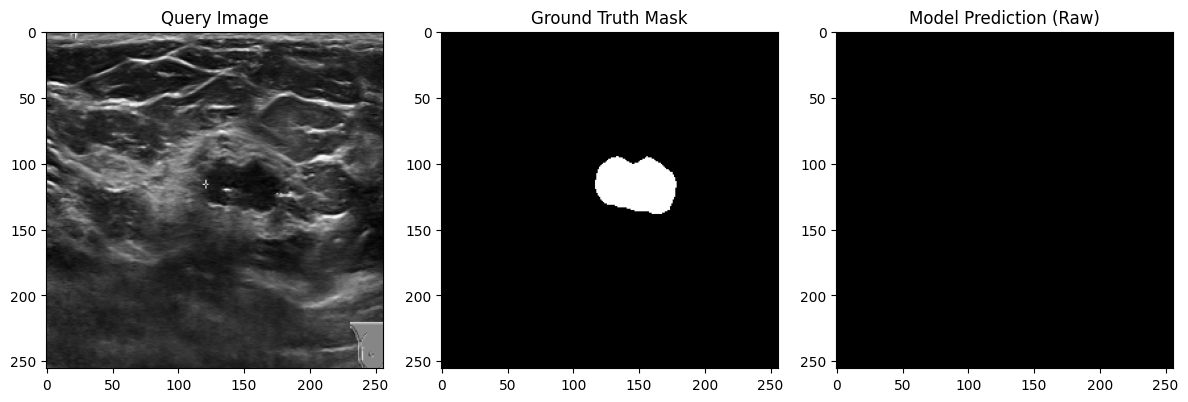

[Epoch 2] Episode 10 | Loss: 1.0694
[Epoch 2] Episode 20 | Loss: 1.1026
[Epoch 2] Episode 30 | Loss: 1.1689
[Epoch 2] Episode 40 | Loss: 1.0477
[Epoch 2] Episode 50 | Loss: 1.1675
[Epoch 2] Episode 60 | Loss: 1.1651
[Epoch 2] Episode 70 | Loss: 1.1660
[Epoch 2] Episode 80 | Loss: 1.2861
[Epoch 2] Episode 90 | Loss: 1.4157
[Epoch 2] Episode 100 | Loss: 1.3920
[Epoch 2] Episode 110 | Loss: 1.1640
[Epoch 2] Episode 120 | Loss: 1.1861
[Epoch 2] Episode 130 | Loss: 1.1626
[Epoch 2] Episode 140 | Loss: 1.2529
[Epoch 2] Episode 150 | Loss: 1.1617
[Epoch 2] Episode 160 | Loss: 1.1615
[Epoch 2] Episode 170 | Loss: 1.0453
[Epoch 2] Episode 180 | Loss: 1.0484
[Epoch 2] Episode 190 | Loss: 1.0289
[Epoch 2] Episode 200 | Loss: 1.1595
[Epoch 2] Episode 210 | Loss: 1.0213
[Epoch 2] Episode 220 | Loss: 1.4037
[Epoch 2] Episode 230 | Loss: 1.0396
[Epoch 2] Episode 240 | Loss: 1.0429
[Epoch 2] Episode 250 | Loss: 1.1567
[Epoch 2] Episode 260 | Loss: 1.1561
[Epoch 2] Episode 270 | Loss: 1.0385
[Epoch 2] 

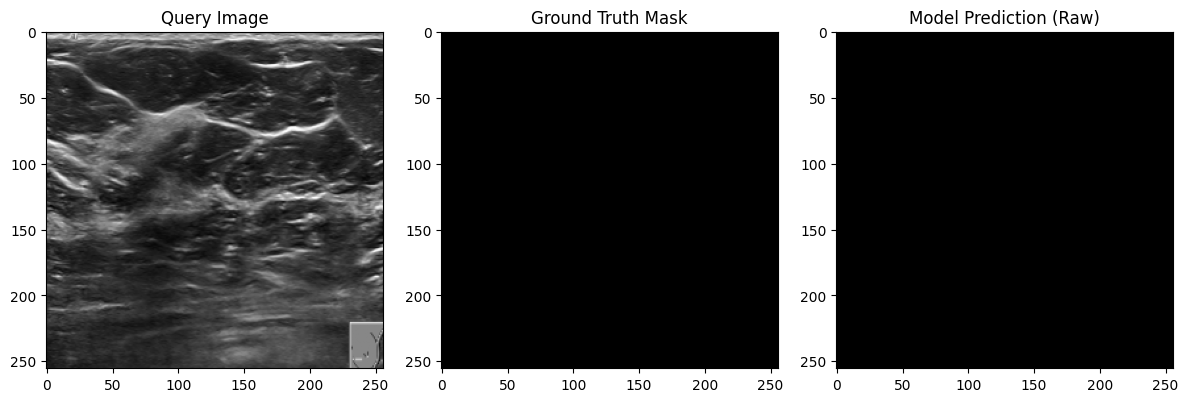

[Epoch 3] Episode 10 | Loss: 1.1257
[Epoch 3] Episode 20 | Loss: 1.0541
[Epoch 3] Episode 30 | Loss: 1.0409
[Epoch 3] Episode 40 | Loss: 1.1244
[Epoch 3] Episode 50 | Loss: 1.5894
[Epoch 3] Episode 60 | Loss: 1.0809
[Epoch 3] Episode 70 | Loss: 1.1515
[Epoch 3] Episode 80 | Loss: 1.1332
[Epoch 3] Episode 90 | Loss: 1.1230
[Epoch 3] Episode 100 | Loss: 1.1225
[Epoch 3] Episode 110 | Loss: 1.1221
[Epoch 3] Episode 120 | Loss: 1.1826
[Epoch 3] Episode 130 | Loss: 1.0738
[Epoch 3] Episode 140 | Loss: 1.0387
[Epoch 3] Episode 150 | Loss: 1.0626
[Epoch 3] Episode 160 | Loss: 1.0413
[Epoch 3] Episode 170 | Loss: 1.1208
[Epoch 3] Episode 180 | Loss: 1.0207
[Epoch 3] Episode 190 | Loss: 1.1200
[Epoch 3] Episode 200 | Loss: 1.3034
[Epoch 3] Episode 210 | Loss: 1.0355
[Epoch 3] Episode 220 | Loss: 1.1190
[Epoch 3] Episode 230 | Loss: 1.1203
[Epoch 3] Episode 240 | Loss: 1.0429
[Epoch 3] Episode 250 | Loss: 1.1209
[Epoch 3] Episode 260 | Loss: 1.1175
[Epoch 3] Episode 270 | Loss: 1.1171
[Epoch 3] 

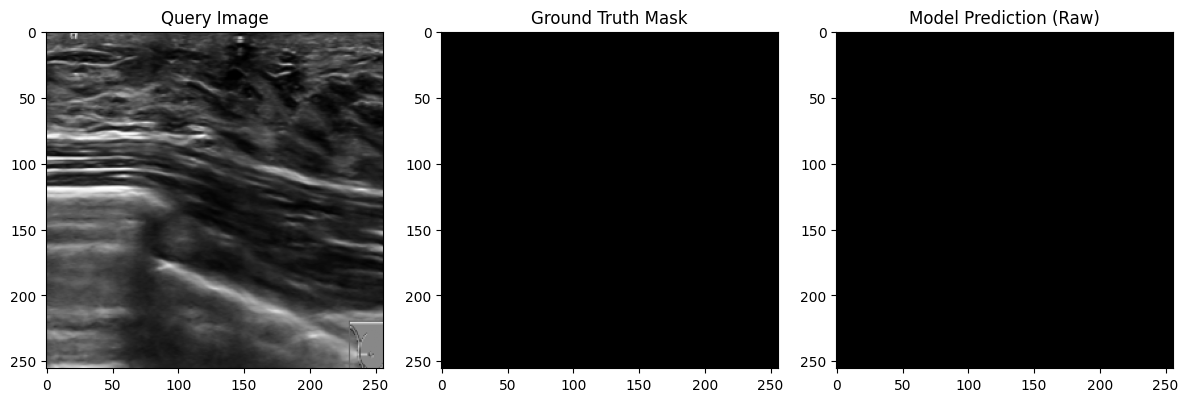

[Epoch 4] Episode 10 | Loss: 1.0220
[Epoch 4] Episode 20 | Loss: 1.0977
[Epoch 4] Episode 30 | Loss: 2.1417
[Epoch 4] Episode 40 | Loss: 1.3550
[Epoch 4] Episode 50 | Loss: 1.0974
[Epoch 4] Episode 60 | Loss: 1.1216
[Epoch 4] Episode 70 | Loss: 1.0972
[Epoch 4] Episode 80 | Loss: 1.0921
[Epoch 4] Episode 90 | Loss: 1.0969
[Epoch 4] Episode 100 | Loss: 1.1020
[Epoch 4] Episode 110 | Loss: 1.0964
[Epoch 4] Episode 120 | Loss: 1.0306
[Epoch 4] Episode 130 | Loss: 1.0563
[Epoch 4] Episode 140 | Loss: 1.0956
[Epoch 4] Episode 150 | Loss: 1.0952
[Epoch 4] Episode 160 | Loss: 1.1188
[Epoch 4] Episode 170 | Loss: 1.0310
[Epoch 4] Episode 180 | Loss: 1.0340
[Epoch 4] Episode 190 | Loss: 1.0983
[Epoch 4] Episode 200 | Loss: 1.0944
[Epoch 4] Episode 210 | Loss: 1.1757
[Epoch 4] Episode 220 | Loss: 1.0939
[Epoch 4] Episode 230 | Loss: 1.0937
[Epoch 4] Episode 240 | Loss: 1.4752
[Epoch 4] Episode 250 | Loss: 1.0998
[Epoch 4] Episode 260 | Loss: 1.0187
[Epoch 4] Episode 270 | Loss: 1.0927
[Epoch 4] 

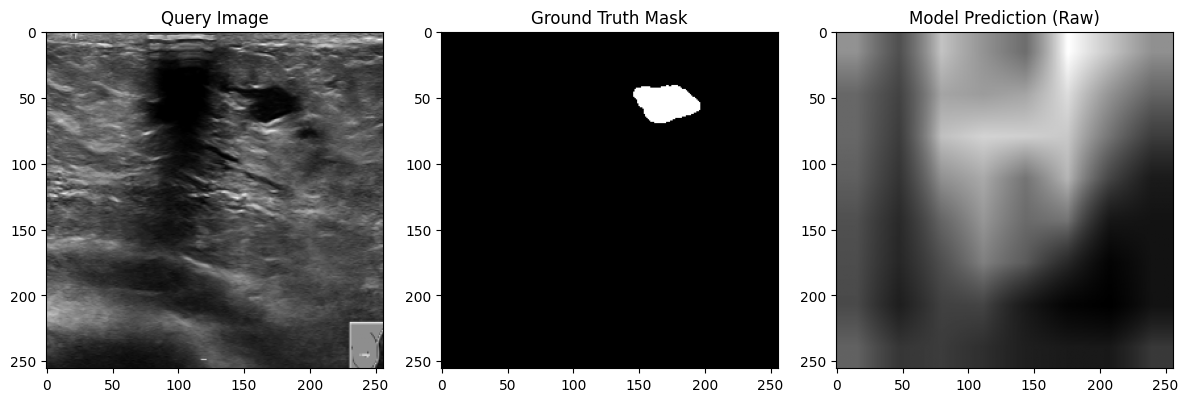

[Epoch 5] Episode 10 | Loss: 1.0316
[Epoch 5] Episode 20 | Loss: 1.1135
[Epoch 5] Episode 30 | Loss: 1.1336
[Epoch 5] Episode 40 | Loss: 1.0326
[Epoch 5] Episode 50 | Loss: 1.0807
[Epoch 5] Episode 60 | Loss: 1.1616
[Epoch 5] Episode 70 | Loss: 1.0186
[Epoch 5] Episode 80 | Loss: 1.0804
[Epoch 5] Episode 90 | Loss: 1.0802
[Epoch 5] Episode 100 | Loss: 1.0799
[Epoch 5] Episode 110 | Loss: 1.0797
[Epoch 5] Episode 120 | Loss: 1.4243
[Epoch 5] Episode 130 | Loss: 1.0334
[Epoch 5] Episode 140 | Loss: 1.0792
[Epoch 5] Episode 150 | Loss: 1.1713
[Epoch 5] Episode 160 | Loss: 1.0791
[Epoch 5] Episode 170 | Loss: 1.0290
[Epoch 5] Episode 180 | Loss: 1.0791
[Epoch 5] Episode 190 | Loss: 1.0914
[Epoch 5] Episode 200 | Loss: 1.4078
[Epoch 5] Episode 210 | Loss: 1.0789
[Epoch 5] Episode 220 | Loss: 1.0788
[Epoch 5] Episode 230 | Loss: 1.0787
[Epoch 5] Episode 240 | Loss: 1.0786
[Epoch 5] Episode 250 | Loss: 1.0785
[Epoch 5] Episode 260 | Loss: 1.0785
[Epoch 5] Episode 270 | Loss: 1.0784
[Epoch 5] 

In [ ]:
import matplotlib.pyplot as plt
def compute_dice(pred, target):
    target = (target > 0.5).float()  # ensure target is also binary
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

def evaluate_model(model, train_loader):
    model.eval()
    dice_scores = []
    with torch.no_grad():
        for support_imgs, support_masks, query_img, query_mask in train_loader:
            support_imgs = support_imgs.squeeze(2).to(device)
            support_masks = support_masks.squeeze(2).to(device)
            query_img = query_img.squeeze(2).to(device)
            query_mask = query_mask.squeeze(2).to(device)

            query_mask = (query_mask > 0.5).float()  # binarize GT mask

            support_masks = (support_masks > 0.5).float()

            pred = model(support_imgs, support_masks, query_img)
            dice = compute_dice(pred, query_mask)
            dice_scores.append(dice.item())
    return sum(dice_scores) / len(dice_scores)


# Training Loop
for epoch in range(10):
    model.train()
    total_loss = 0.0

    for i, (support_imgs, support_masks, query_img, query_mask) in enumerate(train_loader):
        support_imgs = support_imgs.squeeze(2).to(device)     # [N, 1, H, W]
        support_masks = support_masks.squeeze(2).to(device)   # [N, 1, H, W]
        query_img = query_img.squeeze(2).to(device)           # [1, 1, H, W]
        query_mask = query_mask.squeeze(2).to(device)         # [1, 1, H, W]

        query_mask = (query_mask > 0.5).float()  # binarize target mask

        support_masks = (support_masks > 0.5).float()

        pred = model(support_imgs, support_masks, query_img)

        if i == 0:  # Show only the first batch
              plt.figure(figsize=(12, 4))

              plt.subplot(1, 3, 1)
              plt.imshow(query_img.squeeze().cpu(), cmap='gray')
              plt.title("Query Image")

              plt.subplot(1, 3, 2)
              plt.imshow(query_mask.squeeze().cpu(), cmap='gray')
              plt.title("Ground Truth Mask")

              plt.subplot(1, 3, 3)
              plt.imshow(pred.squeeze().cpu().detach(), cmap='gray')
              plt.title("Model Prediction (Raw)")

              plt.tight_layout()
              plt.show()

        loss = dice_loss(pred, query_mask) + nn.BCELoss()(pred, query_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i + 1) % 10 == 0:
            print(f"[Epoch {epoch+1}] Episode {i+1} | Loss: {loss.item():.4f}")

    avg_epoch_loss = total_loss / len(train_loader)
    print(f">>> Epoch {epoch+1} finished. Avg Loss: {avg_epoch_loss:.4f}")

    # Evaluate on validation set
    avg_dice = evaluate_model(model, train_loader)
    print(f" Validation Dice Score after Epoch {epoch+1}: {avg_dice:.4f}\n")